In [1]:
from combined_player import player_minutes_value
from html_scraper import db
from mongo_to_db import create_master_df

In [2]:
import pprint
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_columns', 50)

# Dataframe of Players

In [4]:
games = db.games.find()
players = db.players.find()

In [5]:
final_df = player_minutes_value(games, players)

In [6]:
final_df.head()

,player_id,player_name,club,birthday,age,foot,squad_num,height,total_minutes_played,transfer_value(sterlings),transfer_value(USD)
0,19132.0,Alexander Domínguez,Squad Club Atlético Vélez Sarsfield,"Jun 5, 1987 (31)",31,right,22.0,"1,95 m",1080.000000,£1.58m,2.01
1,27987.0,Lucas Hoyos,Squad Club Atlético Vélez Sarsfield,"Apr 29, 1989 (29)",29,right,12.0,"1,83 m",90.000000,£135k,0.17
2,30896.0,Gastón Díaz,Squad Club Atlético Vélez Sarsfield,"Mar 13, 1988 (30)",30,right,24.0,"1,75 m",896.483333,£450k,0.57
3,94225.0,Joaquín Laso,Squad Club Atlético Vélez Sarsfield,"Jul 4, 1990 (28)",28,right,6.0,"1,85 m",990.000000,£270k,0.34
4,99779.0,Luis Abram,Squad Club Atlético Vélez Sarsfield,"Feb 27, 1996 (22)",22,left,29.0,"1,80 m",1080.000000,£405k,0.51


# Shot Data Dataframe

In [7]:
games = db.games.find()
shots_df = create_master_df(games)

/Users/david/galvanize/super_liga_xg/mongo_to_db.py:69: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  final_df = pd.concat([attach_to_df, df], axis=0, ignore_index=True)
/Users/david/galvanize/super_liga_xg/dataframe_cleaner.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  input_df['is_goal'] = input_df.loc[:, 'shot_type'].isin([9, 11, 12, 13]).astype(int)


In [8]:
shots_df.head()

,game_id,player_id,shot_coord_x1,shot_coord_x2,shot_coord_y1,shot_coord_y2,shot_coord_z1,shot_coord_z2,shot_id,shot_type,team_id,time_of_event(min),passed_from_id,pass_coord_x1,pass_coord_x2,pass_coord_y1,pass_coord_y2,pass_coord_z1,pass_coord_z2,corner_kick,shot_distance,shot_angle,assisted_shot,is_penalty_attempt,is_goal
0,448548,99779.0,6.67,0.00,1.51,-1.21,-1,0.83,22336297,11,20,1.033333,177285.0,0.89,12.44,29.36,-4.84,-1.0,-1.0,1.0,6.838786,12.755990,1,0,1.0
1,448548,60730.0,21.33,12.00,4.24,-0.91,-1,0.73,22336386,35,20,9.683333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,21.747333,11.242763,0,0,0.0
2,448548,177285.0,12.00,1.78,0.00,-3.03,-1,0.21,22336583,13,20,26.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,12.000000,0.000000,0,1,1.0
3,448548,185745.0,8.44,0.89,14.53,-6.66,-1,-1.00,22336723,33,20,38.883333,177285.0,22.67,6.22,3.93,19.67,-1.0,-1.0,0.0,16.803407,59.849102,1,0,0.0
4,448548,77892.0,22.22,0.44,13.92,-8.48,-1,-1.00,22336739,33,13,40.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,26.220122,32.065607,0,0,0.0


# Model Training

In [9]:
from model_prep import create_training_df, create_test_df, create_xG_df, create_summed_xG_df, create_test_min_df, merged_dataframes

In [303]:
train_data, train_y, indices, hold_test = create_training_df(shots_df)
test_data, test_y, indices1, holdout, test = create_test_df(shots_df, hold_test)

In [304]:
print(len(holdout))
#holdout is game_id where as the other two are shot events
print(len(train_data))
len(test_data)

60
1099


777

holdout is 54 games to train on again

training data is 1240 shots - rougly 60 games...

test data is 677 shots - roughly 34 games...

In [305]:
1240 / 20

62.0

# Running XGBoost, RF, Gradient Boosting, Ensemble

In [306]:
from sklearn.metrics import log_loss
from sklearn.ensemble import  RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [307]:
columns_to_predict_on = ['shot_distance', 'shot_angle', 'assisted_shot', 'is_penalty_attempt']

In [308]:
xgboost_model = XGBClassifier(learning_rate = 0.01, max_depth = 3, n_estimators = 300, random_state=8)
gradient_boost_model = GradientBoostingClassifier(learning_rate=0.01, max_depth=4, max_features='log2', min_samples_leaf=4, n_estimators=280, subsample=0.25, random_state=8)
random_forest_model = RandomForestClassifier(n_estimators=300, max_depth=3, verbose=1, random_state=8)

xgboost_model.fit(train_data[columns_to_predict_on], train_y)
gradient_boost_model.fit(train_data[columns_to_predict_on], train_y)
random_forest_model.fit(train_data[columns_to_predict_on], train_y)

p_random_forest = random_forest_model.predict_proba(test_data[columns_to_predict_on])
p_gradient_boost =  gradient_boost_model.predict_proba(test_data[columns_to_predict_on])
p_xgboost = xgboost_model.predict_proba(test_data[columns_to_predict_on])

#need to concat these two arrays somehow...
ensemble_p_0 = (p_random_forest[:,0] + p_gradient_boost[:,0] + p_xgboost[:,0])/3
ensemble_p_1 = (p_random_forest[:,1] + p_gradient_boost[:,1] + p_xgboost[:,1])/3
# ensemble_p = np.concatenate(ensemble_p_0, ensemble_p_1, axis=0)

random_forest_ll = log_loss(test_y, p_random_forest)
gradient_boost_ll = log_loss(test_y, p_gradient_boost)
xgboost_ll = log_loss(test_y, p_xgboost)
# ensemble_ll = log_loss(test_y, ensemble_p)
                                     

print("Ensemble Log Loss " + str(ensemble_ll))
print("Gradient Boost Log Loss " + str(gradient_boost_ll))
print("Random Forest Log Loss " + str(random_forest_ll))
print("XGBoost Log Loss " + str(xgboost_ll))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Ensemble Log Loss 0.32259131196059976
Gradient Boost Log Loss 0.3087515586205469
Random Forest Log Loss 0.3013186718892077
XGBoost Log Loss 0.3052942265338112


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


# predicting on holdoutset with turned parameters

In [309]:
from model_prep import use_holdout_df

In [310]:
test_data, test_y, indiecs1 = use_holdout_df(shots_df, holdout)

In [311]:
p_random_forest = random_forest_model.predict_proba(test_data[columns_to_predict_on])
p_gradient_boost =  gradient_boost_model.predict_proba(test_data[columns_to_predict_on])
p_xgboost = xgboost_model.predict_proba(test_data[columns_to_predict_on])

random_forest_ll = log_loss(test_y, p_random_forest)
gradient_boost_ll = log_loss(test_y, p_gradient_boost)
xgboost_ll = log_loss(test_y, p_xgboost)

print("Gradient Boost Log Loss " + str(gradient_boost_ll))
print("Random Forest Log Loss " + str(random_forest_ll))
print("XGBoost Log Loss " + str(xgboost_ll))

Gradient Boost Log Loss 0.2961314317026644
Random Forest Log Loss 0.29354163510244663
XGBoost Log Loss 0.2954665596792828


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


# pickle models

In [312]:
import pickle

In [316]:
rf_pkl_filename = 'rfc.pkl'
rf_pkl = open(rf_pkl_filename, 'wb')
pickle.dump(random_forest_model, rf_pkl)
rf_pkl.close()

gb_pkl_filename = 'gb.pkl'
gb_pkl = open(gb_pkl_filename, 'wb')
pickle.dump(gradient_boost_model, gb_pkl)
gb_pkl.close()

xgb_pkl_filename = 'xgb.pkl'
xgb_pkl = open(xgb_pkl_filename, 'wb')
pickle.dump(xgboost_model, xgb_pkl)
xgb_pkl.close()





# xG and minutes for various models

In [272]:
rf_xg = create_xG_df(test_data, test_y, p_random_forest)
rf_contributions = create_summed_xG_df(rf_xg)

gb_xg = create_xG_df(test_data, test_y, p_gradient_boost)
gb_contributions = create_summed_xG_df(gb_xg)

xgb_xg = create_xG_df(test_data, test_y, p_xgboost)
xgb_contributions = create_summed_xG_df(xgb_xg)

# ensem_xg = create_xG_df(test_data, test_y, ensemble_p)
# ensem_contributions = create_summed_xG_df(ensem_xg)

In [273]:
rf_contributions.head(20)

,player_id,total_xG,total_xA,total_xG+xA,goals
0,16081.0,2.57,1.00,3.57,4.0
1,3148.0,1.83,1.43,3.26,1.0
2,488.0,1.73,0.26,1.99,4.0
3,15113.0,1.66,0.31,1.97,1.0
4,30266.0,1.54,0.42,1.96,3.0
5,98292.0,1.53,0.33,1.86,2.0
6,47913.0,1.41,0.06,1.47,2.0
7,24256.0,1.39,1.00,2.39,2.0
8,17266.0,1.39,0.31,1.70,2.0
9,618.0,1.33,0.12,1.45,1.0


In [274]:
gb_contributions.head(20)

,player_id,total_xG,total_xA,total_xG+xA,goals
0,16081.0,2.48,0.97,3.45,4.0
1,488.0,1.73,0.21,1.94,4.0
2,3148.0,1.66,1.26,2.92,1.0
3,24256.0,1.62,1.10,2.72,2.0
4,15113.0,1.61,0.33,1.94,1.0
5,30266.0,1.40,0.46,1.86,3.0
6,209887.0,1.35,0.05,1.40,0.0
7,98292.0,1.34,0.30,1.64,2.0
8,36681.0,1.29,0.00,1.29,0.0
9,17217.0,1.24,0.41,1.65,2.0


In [275]:
xgb_contributions.head(20)

,player_id,total_xG,total_xA,total_xG+xA,goals
0,16081.0,3.04,1.34,4.38,4.0
1,3148.0,1.99,1.47,3.46,1.0
2,15113.0,1.87,0.42,2.29,1.0
3,488.0,1.80,0.21,2.01,4.0
4,30266.0,1.68,0.52,2.20,3.0
5,24256.0,1.64,1.17,2.81,2.0
6,98292.0,1.63,0.41,2.04,2.0
7,17217.0,1.56,0.64,2.20,2.0
8,17266.0,1.51,0.41,1.92,2.0
9,47913.0,1.49,0.07,1.56,2.0


# looking at probability by area

In [276]:
from create_shot_coordinates import shot_probability_player, coord_table

In [277]:
six, eighteen, eighteen_plus, left_box, right_box = shot_probability_player()

### average probability of shot in the six yard box

In [278]:
p_random_forest6 = random_forest_model.predict_proba(six)
p_gradient_boost6 =  gradient_boost_model.predict_proba(six)
p_xgboost6 = xgboost_model.predict_proba(six)

p_6_rf = p_random_forest6.sum(axis=0)[1] / len(p_random_forest6)
p_6_gb = p_gradient_boost6.sum(axis=0)[1] / len(p_gradient_boost6)
p_6_xgb = p_xgboost6.sum(axis=0)[1] / len(p_xgboost6)

print(p_6_rf)
print(p_6_gb)
print(p_6_xgb)

0.23464200402821322
0.2652304979414651
0.25252105250503076


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


In [279]:
six_yard_shot = coord_table(-10, 10, 2, 2, 6, 2)

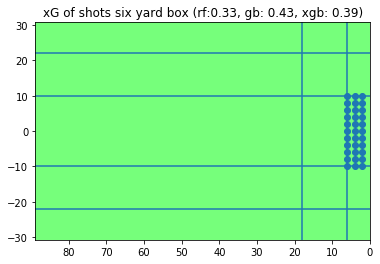

In [280]:
fig, ax = plt.subplots()
ax.scatter(six_yard_shot['shot_coord_x1'], six_yard_shot['shot_coord_y1'])
# ax.scatter(shot_distance_df['pass_coord_x1'], shot_distance_df['pass_coord_y1'], color='red')
# ax.scatter(transposed_df['pass_coord_x2'], transposed_df['pass_coord_y2'], color='yellow')
ax.set_title('xG of shots six yard box (rf:0.33, gb: 0.43, xgb: 0.39)')
ax.set_xlim([88.88, 0])
ax.set_ylim([-30.76, 30.76])
ax.axvline(6)
ax.axvline(18)
ax.axhline(10, xmax=6)
ax.axhline(-10, xmax=6)
ax.axhline(22, xmax=18)
ax.axhline(-22, xmax=18)
ax.set_facecolor('xkcd:lightgreen')

### average probability of shot in the eighteen yard box

In [281]:
p_random_forest18 = random_forest_model.predict_proba(eighteen)
p_gradient_boost18 =  gradient_boost_model.predict_proba(eighteen)
p_xgboost18 = xgboost_model.predict_proba(eighteen)

p_18_rf = p_random_forest18.sum(axis=0)[1] / len(p_random_forest18)
p_18_gb = p_gradient_boost18.sum(axis=0)[1] / len(p_gradient_boost18)
p_18_xgb = p_xgboost18.sum(axis=0)[1] / len(p_xgboost18)

print(p_18_rf)
print(p_18_gb)
print(p_18_xgb)

0.1067934988882113
0.11162370710815266
0.1383587374831691


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


In [282]:
eighteen_yard_shot = coord_table(-10, 10, 2, 8, 18, 2)

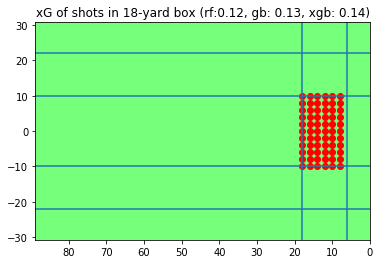

In [283]:
fig, ax = plt.subplots()
ax.scatter(eighteen_yard_shot['shot_coord_x1'], eighteen_yard_shot['shot_coord_y1'], color='red')
# ax.scatter(shot_distance_df['pass_coord_x1'], shot_distance_df['pass_coord_y1'], color='red')
# ax.scatter(transposed_df['pass_coord_x2'], transposed_df['pass_coord_y2'], color='yellow')
ax.set_title('xG of shots in 18-yard box (rf:0.12, gb: 0.13, xgb: 0.14)')
ax.set_xlim([88.88, 0])
ax.set_ylim([-30.76, 30.76])
ax.axvline(6)
ax.axvline(18)
ax.axhline(10, xmax=6)
ax.axhline(-10, xmax=6)
ax.axhline(22, xmax=18)
ax.axhline(-22, xmax=18)
ax.set_facecolor('xkcd:lightgreen')

### average probability of shot beyond eighteen yard box

In [284]:
p_random_forest18p = random_forest_model.predict_proba(eighteen_plus)
p_gradient_boost18p =  gradient_boost_model.predict_proba(eighteen_plus)
p_xgboost18p = xgboost_model.predict_proba(eighteen_plus)

p_18p_rf = p_random_forest18p.sum(axis=0)[1] / len(p_random_forest18p)
p_18p_gb = p_gradient_boost18p.sum(axis=0)[1] / len(p_gradient_boost18p)
p_18p_xgb = p_xgboost18p.sum(axis=0)[1] / len(p_xgboost18p)

print(p_18p_rf)
print(p_18p_gb)
print(p_18p_xgb)

0.05548285326475946
0.043589436036406484
0.05567752451136492


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


In [285]:
beyond_eighteen_yard_shot = coord_table(-22, 22, 2, 20, 30, 2)

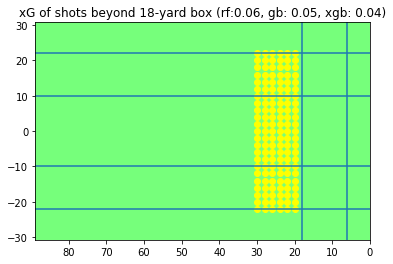

In [286]:
fig, ax = plt.subplots()
ax.scatter(beyond_eighteen_yard_shot['shot_coord_x1'], beyond_eighteen_yard_shot['shot_coord_y1'], color='yellow')
# ax.scatter(shot_distance_df['pass_coord_x1'], shot_distance_df['pass_coord_y1'], color='red')
# ax.scatter(transposed_df['pass_coord_x2'], transposed_df['pass_coord_y2'], color='yellow')
ax.set_title('xG of shots beyond 18-yard box (rf:0.06, gb: 0.05, xgb: 0.04)')
ax.set_xlim([88.88, 0])
ax.set_ylim([-30.76, 30.76])
ax.axvline(6)
ax.axvline(18)
ax.axhline(10, xmax=6)
ax.axhline(-10, xmax=6)
ax.axhline(22, xmax=18)
ax.axhline(-22, xmax=18)
ax.set_facecolor('xkcd:lightgreen')

### average probability of shot left of six

In [287]:
p_random_forest6l = random_forest_model.predict_proba(left_box)
p_gradient_boost6l =  gradient_boost_model.predict_proba(left_box)
p_xgboost6l = xgboost_model.predict_proba(left_box)

p_6l_rf = p_random_forest6l.sum(axis=0)[1] / len(p_random_forest6l)
p_6l_gb = p_gradient_boost6l.sum(axis=0)[1] / len(p_gradient_boost6l)
p_6l_xgb = p_xgboost6l.sum(axis=0)[1] / len(p_xgboost6l)

print(p_6l_rf)
print(p_6l_gb)
print(p_6l_xgb)

0.060648215717905796
0.05554442688304999
0.08049916558795506


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


In [288]:
left_six_yard_shot = coord_table(12, 22, 2, 3, 18, 3)

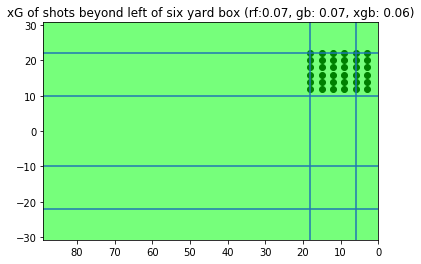

In [289]:
fig, ax = plt.subplots()
ax.scatter(left_six_yard_shot['shot_coord_x1'], left_six_yard_shot['shot_coord_y1'], color='green')
ax.set_title('xG of shots beyond left of six yard box (rf:0.07, gb: 0.07, xgb: 0.06)')
ax.set_xlim([88.88, 0])
ax.set_ylim([-30.76, 30.76])
ax.axvline(6)
ax.axvline(18)
ax.axhline(10, xmax=6)
ax.axhline(-10, xmax=6)
ax.axhline(22, xmax=18)
ax.axhline(-22, xmax=18)
ax.set_facecolor('xkcd:lightgreen')

### average probability of shot right of six

In [290]:
p_random_forest6r = random_forest_model.predict_proba(right_box)
p_gradient_boost6r =  gradient_boost_model.predict_proba(right_box)
p_xgboost6r = xgboost_model.predict_proba(right_box)

p_6r_rf = p_random_forest6r.sum(axis=0)[1] / len(p_random_forest6r)
p_6r_gb = p_gradient_boost6r.sum(axis=0)[1] / len(p_gradient_boost6r)
p_6r_xgb = p_xgboost6r.sum(axis=0)[1] / len(p_xgboost6r)

print(p_6r_rf)
print(p_6r_gb)
print(p_6r_xgb)

0.08234919647698909
0.08737162659359253
0.08362292581134373


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


In [291]:
right_six_yard_shot = coord_table(-12, -22, -2, 3, 18, 3)

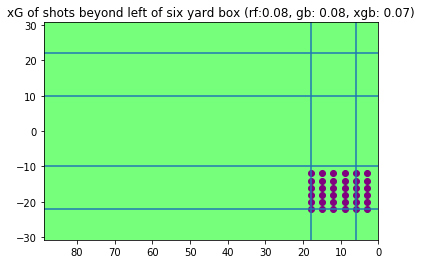

In [292]:
fig, ax = plt.subplots()
ax.scatter(right_six_yard_shot['shot_coord_x1'], right_six_yard_shot['shot_coord_y1'], color='purple')
ax.set_title('xG of shots beyond left of six yard box (rf:0.08, gb: 0.08, xgb: 0.07)')
ax.set_xlim([88.88, 0])
ax.set_ylim([-30.76, 30.76])
ax.axvline(6)
ax.axvline(18)
ax.axhline(10, xmax=6)
ax.axhline(-10, xmax=6)
ax.axhline(22, xmax=18)
ax.axhline(-22, xmax=18)
ax.set_facecolor('xkcd:lightgreen')

In [ ]:
# fig, ax = plt.subplots()
# ax.scatter(six_yard_shot['shot_coord_x1'], six_yard_shot['shot_coord_y1'])
# ax.scatter(eighteen_yard_shot['shot_coord_x1'], eighteen_yard_shot['shot_coord_y1'], color='red')
# ax.scatter(beyond_eighteen_yard_shot['shot_coord_x1'], beyond_eighteen_yard_shot['shot_coord_y1'], color='yellow')
# ax.scatter(left_six_yard_shot['shot_coord_x1'], left_six_yard_shot['shot_coord_y1'], color='green')
# ax.scatter(right_six_yard_shot['shot_coord_x1'], right_six_yard_shot['shot_coord_y1'], color='purple')
# # ax.scatter(shot_distance_df['pass_coord_x1'], shot_distance_df['pass_coord_y1'], color='red')
# # ax.scatter(transposed_df['pass_coord_x2'], transposed_df['pass_coord_y2'], color='yellow')
# ax.set_title('xG of Shots in Box for Tomás Pochettino x: blue:0.79, red: 0.80, yellow: 0.79, green: 0.80, purple: 0.80')
# ax.set_xlim([88.88, 0])
# ax.set_ylim([-30.76, 30.76])
# ax.axvline(6)
# ax.axvline(18)
# ax.axhline(10, xmax=6)
# ax.axhline(-10, xmax=6)
# ax.axhline(22, xmax=18)
# ax.axhline(-22, xmax=18)
# ax.set_facecolor('xkcd:lightgreen')

# Parameter tuning

In [141]:
from model_prep import stage_score_plot

In [232]:
train_data, train_y, indices, hold_test = create_training_df(shots_df)
test_data, test_y, indices1, holdout, test = create_test_df(shots_df, hold_test)
columns_to_predict_on = ['shot_distance', 'shot_angle', 'assisted_shot', 'is_penalty_attempt']

In [242]:
gbm1 = GradientBoostingClassifier(learning_rate=0.01, max_depth=1, max_features='log2', min_samples_leaf=4, n_estimators=300, subsample=0.25, random_state=8)
gbm2 = GradientBoostingClassifier(learning_rate=0.01, max_depth=2, max_features='log2', min_samples_leaf=4, n_estimators=300, subsample=0.25, random_state=8)
gbm3 = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, max_features='log2', min_samples_leaf=4, n_estimators=300, subsample=0.25, random_state=8)
gbm4 = GradientBoostingClassifier(learning_rate=0.01, max_depth=4, max_features='log2', min_samples_leaf=4, n_estimators=300, subsample=0.25, random_state=8)
gbm5 = GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features='log2', min_samples_leaf=4, n_estimators=300, subsample=0.25, random_state=8)
gbm6 = GradientBoostingClassifier(learning_rate=0.01, max_depth=6, max_features='log2', min_samples_leaf=4, n_estimators=300, subsample=0.25, random_state=8)

gbm1.fit(train_data[columns_to_predict_on], train_y)
gbm2.fit(train_data[columns_to_predict_on], train_y)
gbm3.fit(train_data[columns_to_predict_on], train_y)
gbm4.fit(train_data[columns_to_predict_on], train_y)
gbm5.fit(train_data[columns_to_predict_on], train_y)
gbm6.fit(train_data[columns_to_predict_on], train_y)

pgb1 =  gbm1.predict_proba(test_data[columns_to_predict_on])
pgb2 =  gbm2.predict_proba(test_data[columns_to_predict_on])
pgb3 =  gbm3.predict_proba(test_data[columns_to_predict_on])
pgb4 =  gbm4.predict_proba(test_data[columns_to_predict_on])
pgb5 =  gbm5.predict_proba(test_data[columns_to_predict_on])
pgb6 =  gbm6.predict_proba(test_data[columns_to_predict_on])


gb1_ll = log_loss(test_y, pgb1)
gb2_ll = log_loss(test_y, pgb2)
gb3_ll = log_loss(test_y, pgb3)
gb4_ll = log_loss(test_y, pgb4)
gb5_ll = log_loss(test_y, pgb5)
gb6_ll = log_loss(test_y, pgb6)

print("GB depth 1 log loss " + str(gb1_ll))
print("GB depth 2 log loss " + str(gb2_ll))
print("GB depth 3 log loss " + str(gb3_ll))
print("GB depth 4 log loss " + str(gb4_ll))
print("GB depth 5 log loss " + str(gb5_ll))
print("GB depth 6 log loss " + str(gb6_ll))

GB depth 1 log loss 0.2710384886798697
GB depth 2 log loss 0.2719155931617161
GB depth 3 log loss 0.2738609773730559
GB depth 4 log loss 0.27501841465885396
GB depth 5 log loss 0.2774668087333602
GB depth 6 log loss 0.2805344888384963


### best gb is depth of 3, 188 trees

lowest test error(log loss): 0.27096120354482794
num_trees at lowest test error: 298


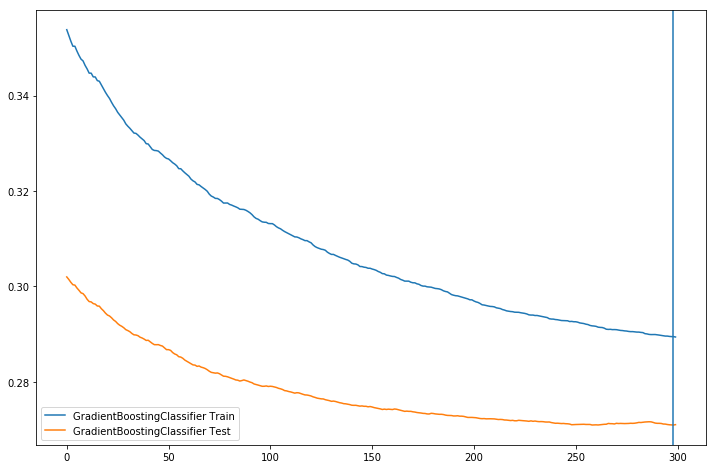

In [243]:
stage_score_plot(gbm1, train_data[columns_to_predict_on], train_y, test_data[columns_to_predict_on], test_y)

lowest test error(log loss): 0.27171840858728824
num_trees at lowest test error: 297


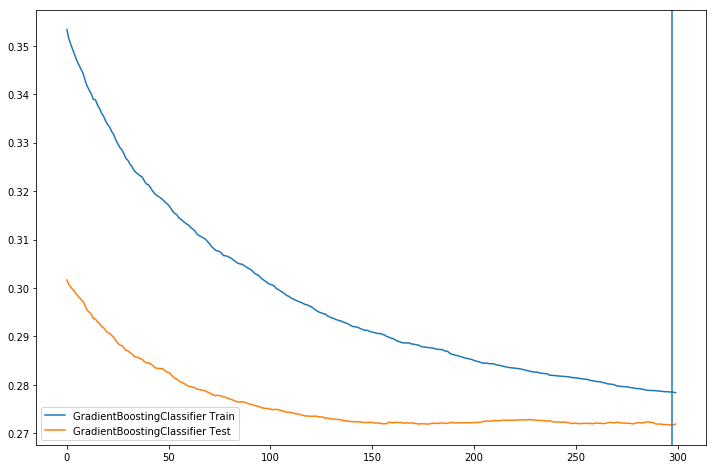

In [244]:
stage_score_plot(gbm2, train_data[columns_to_predict_on], train_y, test_data[columns_to_predict_on], test_y)

lowest test error(log loss): 0.27274536657331333
num_trees at lowest test error: 146


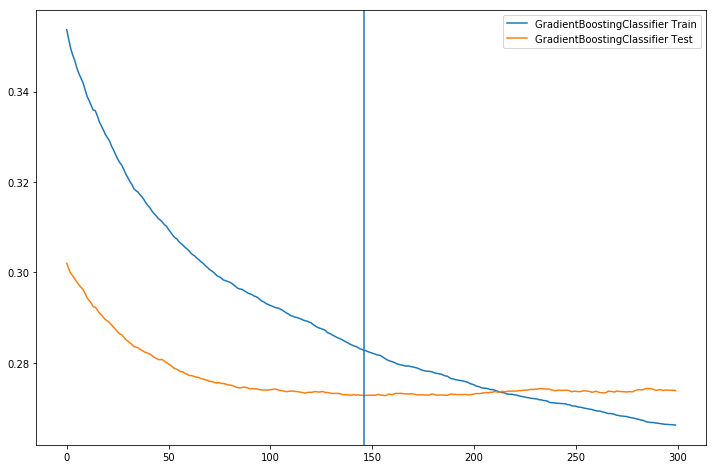

In [245]:
stage_score_plot(gbm3, train_data[columns_to_predict_on], train_y, test_data[columns_to_predict_on], test_y)

lowest test error(log loss): 0.27271117652816523
num_trees at lowest test error: 139


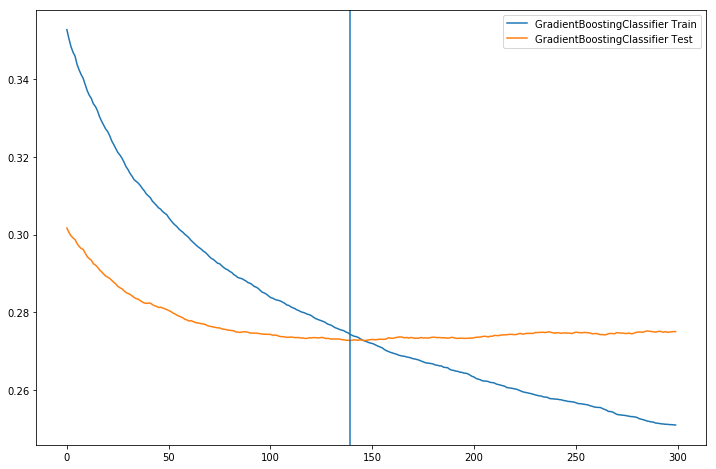

In [246]:
stage_score_plot(gbm4, train_data[columns_to_predict_on], train_y, test_data[columns_to_predict_on], test_y)

lowest test error(log loss): 0.27274525931856525
num_trees at lowest test error: 139


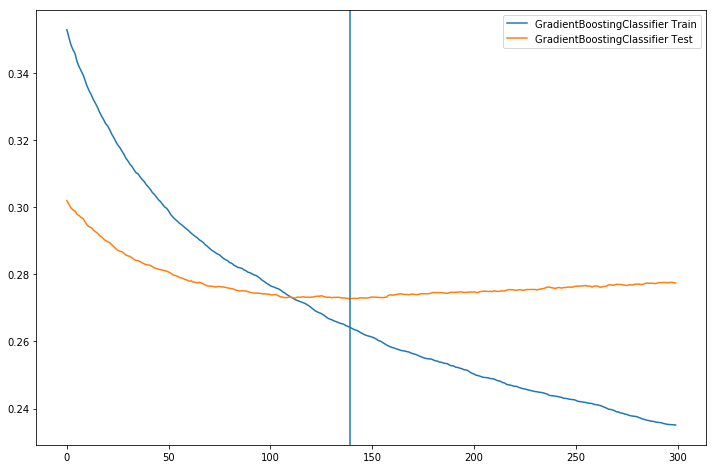

In [247]:
stage_score_plot(gbm5, train_data[columns_to_predict_on], train_y, test_data[columns_to_predict_on], test_y)

lowest test error(log loss): 0.2739072538485309
num_trees at lowest test error: 139


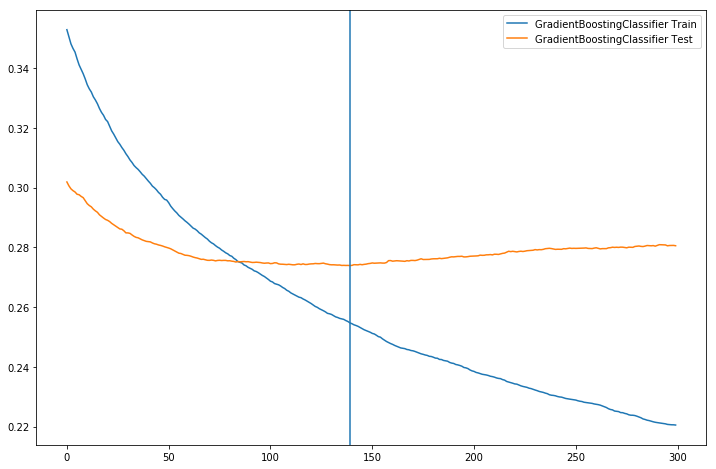

In [248]:
stage_score_plot(gbm6, train_data[columns_to_predict_on], train_y, test_data[columns_to_predict_on], test_y)

### tuning xgboost

In [260]:
train_data, train_y, indices, hold_test = create_training_df(shots_df)
test_data, test_y, indices1, holdout, test = create_test_df(shots_df, hold_test)
columns_to_predict_on = ['shot_distance', 'shot_angle', 'assisted_shot', 'is_penalty_attempt']

In [261]:
xgb1 = XGBClassifier(learning_rate=0.01, n_estimators=200, random_state=8)
xgb2 = XGBClassifier(learning_rate=0.01, n_estimators=300, random_state=8)
xgb3 = XGBClassifier(learning_rate=0.01, n_estimators=400, random_state=8)
xgb4 = XGBClassifier(learning_rate=0.01, n_estimators=500, random_state=8)
xgb5 = XGBClassifier(learning_rate=0.01, n_estimators=600, random_state=8)

xgb1.fit(train_data[columns_to_predict_on], train_y)
xgb2.fit(train_data[columns_to_predict_on], train_y)
xgb3.fit(train_data[columns_to_predict_on], train_y)
xgb4.fit(train_data[columns_to_predict_on], train_y)
xgb5.fit(train_data[columns_to_predict_on], train_y)


xgb_p1 =  xgb1.predict_proba(test_data[columns_to_predict_on])
xgb_p2 =  xgb2.predict_proba(test_data[columns_to_predict_on])
xgb_p3 =  xgb3.predict_proba(test_data[columns_to_predict_on])
xgb_p4 =  xgb4.predict_proba(test_data[columns_to_predict_on])
xgb_p5 =  xgb5.predict_proba(test_data[columns_to_predict_on])



xgb1_ll = log_loss(test_y, xgb_p1)
xgb2_ll = log_loss(test_y, xgb_p2)
xgb3_ll = log_loss(test_y, xgb_p3)
xgb4_ll = log_loss(test_y, xgb_p4)
xgb5_ll = log_loss(test_y, xgb_p5)


print("GB depth 1 log loss " + str(xgb1_ll))
print("GB depth 2 log loss " + str(xgb2_ll))
print("GB depth 3 log loss " + str(xgb3_ll))
print("GB depth 4 log loss " + str(xgb4_ll))
print("GB depth 5 log loss " + str(xgb5_ll))

GB depth 1 log loss 0.3326660981285386
GB depth 2 log loss 0.32455047439434564
GB depth 3 log loss 0.32742997480672786
GB depth 4 log loss 0.3300564275326906
GB depth 5 log loss 0.33388707239646465


In [262]:
stage_score_plot(xgb1, train_data[columns_to_predict_on], train_y, test_data[columns_to_predict_on], test_y)

AttributeError: 'XGBClassifier' object has no attribute 'staged_predict_proba'